In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Flatten
from keras.utils import to_categorical
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


labels.csv
sample_submission.csv
test
train



In [2]:
files = glob('../input/train/*.jpg')
labels = pd.read_csv('../input/labels.csv')

In [3]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


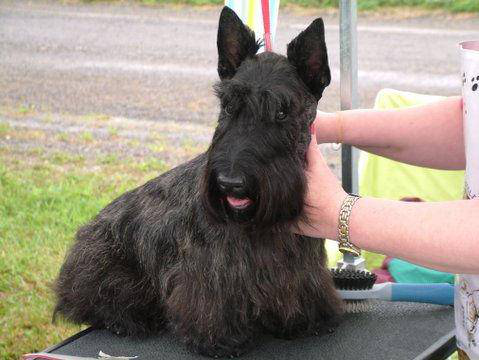

In [4]:
Image.open(files[0])

In [5]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,d11ef31e3d37fd218db0fcc76e416241,scottish_deerhound
freq,1,126


In [6]:
df = labels.breed.value_counts().reset_index()

In [7]:
df[-10:]

,index,breed
110,tibetan_mastiff,69
111,otterhound,69
112,giant_schnauzer,69
113,german_shepherd,69
114,walker_hound,69
115,golden_retriever,67
116,komondor,67
117,brabancon_griffon,67
118,briard,66
119,eskimo_dog,66


In [8]:
df.describe()

,breed
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000


In [9]:
imgs = np.empty([len(files),224,224,3],dtype='uint8')
for i in tqdm(range(len(files))):
    imgs[i] = Image.open(files[i]).resize((224,224));
#imgs2 = np.array([np.array(Image.open(file).resize((224,224))) for file in tqdm(files[:99])])

100%|██████████| 10222/10222 [01:55<00:00, 88.79it/s]


In [10]:
ids = [file.split('/')[-1].split('.')[0] for file in files]
id_val = dict(zip(labels.id,labels.breed))
label_ids = [id_val[id] for id in ids]
label_index = {label:i for i,label in enumerate(np.unique(label_ids))}
labels_id = [label_index[label] for label in label_ids]

In [11]:
labels_onehot_encoded = to_categorical(labels_id,num_classes=120)

In [12]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [13]:
model = Sequential(base_model.layers[:7])

In [ ]:
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(120,activation='softmax'))
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
model.fit(imgs,labels_onehot_encoded,
          batch_size=8,
          validation_split=0.3,
         verbose=1)

Train on 7155 samples, validate on 3067 samples
Epoch 1/1


In [ ]:
np.array(imgs).shape